<a href="https://colab.research.google.com/github/goshdangy/assignment03/blob/main/Ice_Velocity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/drive')

# Load data from the ASCII file (assuming two columns: depth z and velocity vo)
data = np.loadtxt('/content/drive/MyDrive/FALL 2024/GEOS522 - Geostatistics & Data Analysis/GEOPH522_Fall2024/HW/HW3/icevelocity.txt')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


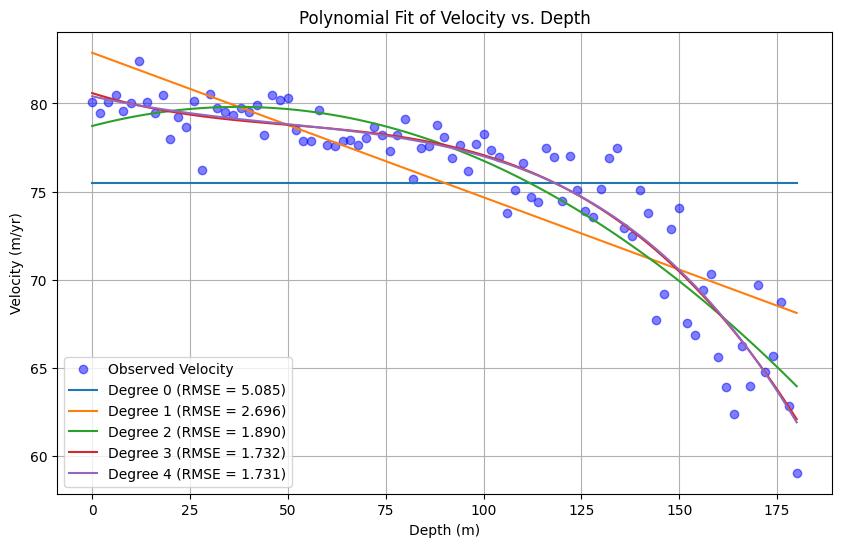

In [7]:
#1

# Load the ice velocity data
z = data[:, 0]  # Depth values (m)
v = data[:, 1]  # Observed velocities (m/yr)

# Fit polynomial models of degrees 0 to 4
degrees = [0, 1, 2, 3, 4]
polynomials = []
rmse_values = []

plt.figure(figsize=(10, 6))
plt.plot(z, v, 'bo', label='Observed Velocity', alpha=0.5)

for degree in degrees:
    coefficients = np.polyfit(z, v, degree)
    polynomials.append(coefficients)
    v_model = np.polyval(coefficients, z)
    rmse = np.sqrt(mean_squared_error(v, v_model))
    rmse_values.append(rmse)
    plt.plot(z, v_model, label=f'Degree {degree} (RMSE = {rmse:.3f})')

plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.title('Polynomial Fit of Velocity vs. Depth')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# 2

#Create 3D Array to calculate uncertainty
"""
Task:
- Randomly sampling 90% of the dataset in each iteration.
- Fitting polynomials of degrees 0 through 4 to the sampled data.
- Storing the coefficients in a 3D array.
- Calculating the mean and standard deviation of the coefficients across all iterations.
- Printing the results.
"""

# Number of iterations and sample size (90% of data)
#assuming there is no missing data, we can set our length to 90% of z
n_iterations = 1000
sample_size = int(0.9 * len(z))

"""
For each polynomial of degree n, there are n + 1 coefficients
We calculate the maximum number of coefficients we will need, which is 5 (from the degree-4 polynomial).
This ensures our 3D array has enough space for all coefficients.
"""

# Polynomial degrees to fit
degrees = [0, 1, 2, 3, 4]

# Maximum number of coefficients we need for degree 4 (which has 5 coefficients)
max_coeffs = max([degree + 1 for degree in degrees])

"""
We create a 3D array coefficients_array with dimensions
1000×5×5
(since we have 1000 iterations, 5 polynomial degrees, and a maximum of 5 coefficients.)
Initially, the array is filled with zeros (np.zeros()),
and as we fit polynomials in each iteration, we will populate this array with the coefficients.
"""
# Initialize a 3D array to store coefficients for all iterations and degrees
coefficients_array = np.zeros((n_iterations, len(degrees), max_coeffs))

# Monte Carlo simulation
for i in range(n_iterations):
    indices = np.random.choice(len(z), sample_size, replace=False) # Randomly sample 90% of the data (keeping rows linked)
    z_sample = z[indices] #same indices to link the pairs across rows
    vo_sample = v[indices]

    # Fit polynomial models for each degree
    for j, degree in enumerate(degrees): #each inner loop goes from [0-4]
        coeffs = np.polyfit(z_sample, vo_sample, degree) #For each degree, np.polyfit() is used to fit a polynomial of the given degree to the sampled data
        coefficients_array[i, j, :len(coeffs)] = coeffs # Store the coefficients in the 3D array (fill unused coefficient slots with 0s)
        """
        The first index i refers to the current Monte Carlo iteration, and j refers to the polynomial degree.
        The coefficients are stored in the appropriate slice of the third dimension of the array,
        based on how many coefficients are returned by polyfit.
        """
# Calculate the mean and standard deviation of the parameters for each degree
mean_coeffs = np.mean(coefficients_array, axis=0) #mean = first axis (the iterations). This gives us the mean values of the coefficients for each degree.
std_coeffs = np.std(coefficients_array, axis=0) #std = first axis (the iterations), which provides the uncertainty (variability) in the coefficient estimates.

# Display the results
for j, degree in enumerate(degrees): #looping through the polynomial
    print(f"Degree {degree}:")
    for i in range(degree + 1):
        print(f"  Coefficient A{i}: Mean = {mean_coeffs[j, i]:.5f}, Std = {std_coeffs[j, i]:.5f}")
    print()  # Blank line for readability


Degree 0:
  Coefficient A0: Mean = 75.49852, Std = 0.18953

Degree 1:
  Coefficient A0: Mean = -0.08204, Std = 0.00246
  Coefficient A1: Mean = 82.88220, Std = 0.18380

Degree 2:
  Coefficient A0: Mean = -0.00078, Std = 0.00003
  Coefficient A1: Mean = 0.05816, Std = 0.00506
  Coefficient A2: Mean = 78.71787, Std = 0.16884

Degree 3:
  Coefficient A0: Mean = -0.00001, Std = 0.00000
  Coefficient A1: Mean = 0.00101, Std = 0.00016
  Coefficient A2: Mean = -0.07005, Std = 0.01051
  Coefficient A3: Mean = 80.59345, Std = 0.16979

Degree 4:
  Coefficient A0: Mean = -0.00000, Std = 0.00000
  Coefficient A1: Mean = -0.00000, Std = 0.00000
  Coefficient A2: Mean = 0.00050, Std = 0.00051
  Coefficient A3: Mean = -0.04976, Std = 0.01855
  Coefficient A4: Mean = 80.41958, Std = 0.17177



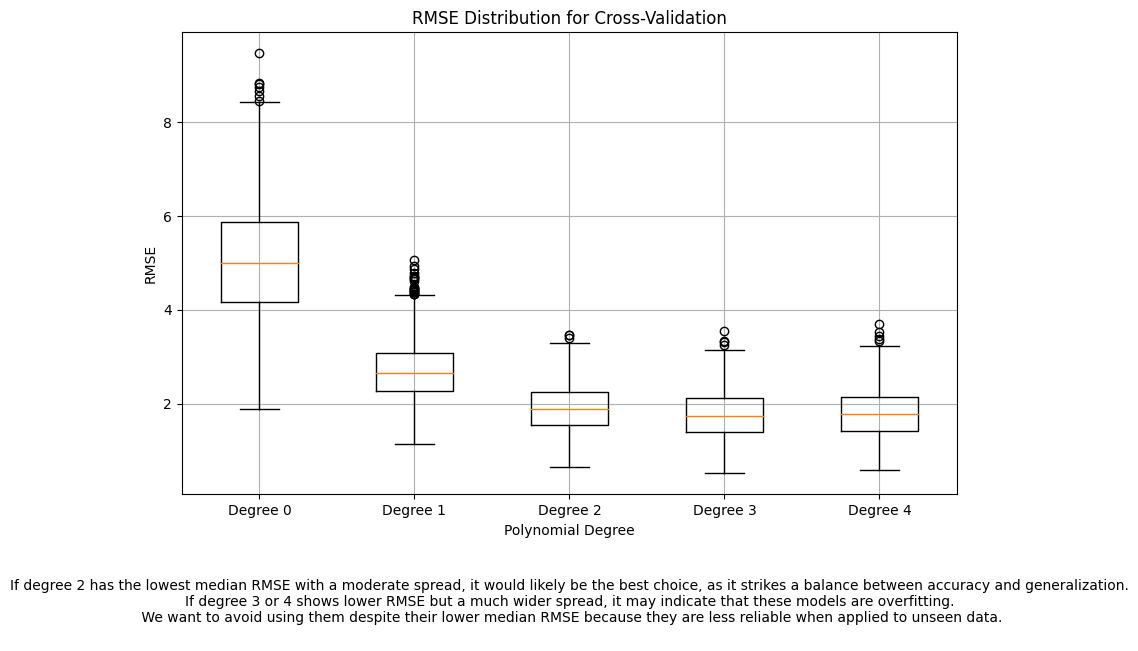

In [18]:
# Question 3: Cross-Validation for RMSE
from sklearn.model_selection import train_test_split

degrees = [0, 1, 2, 3, 4]  # List of polynomial degrees to fit
rmse_distributions = {degree: [] for degree in degrees}  # Dictionary to store RMSE values for each degree

for _ in range(1000):
    z_train, z_test, v_train, v_test = train_test_split(z, v, test_size=0.1)  # Split data into 90% train and 10% test
    for degree in degrees:
        coefficients = np.polyfit(z_train, v_train, degree)  # Fit polynomial to training data
        v_test_pred = np.polyval(coefficients, z_test)  # Predict velocities for test data
        rmse = np.sqrt(mean_squared_error(v_test, v_test_pred))  # Calculate RMSE for test data
        rmse_distributions[degree].append(rmse)  # Store the RMSE value

plt.figure(figsize=(10, 6))  # Create a new figure
plt.boxplot([rmse_distributions[degree] for degree in degrees], labels=[f'Degree {degree}' for degree in degrees])  # Create box plot for each degree
plt.xlabel('Polynomial Degree')  # Label x-axis
plt.ylabel('RMSE')  # Label y-axis
plt.title('RMSE Distribution for Cross-Validation')  # Title of the plot
plt.grid(True)  # Add gridlines to the plot
plt.text(0.5, -0.25, "If degree 2 has the lowest median RMSE with a moderate spread, it would likely be the best choice, as it strikes a balance between accuracy and generalization.\n"
"If degree 3 or 4 shows lower RMSE but a much wider spread, it may indicate that these models are overfitting.\n"
" We want to avoid using them despite their lower median RMSE because they are less reliable when applied to unseen data.\n",
         ha='center', va='center', fontsize=10, transform=plt.gca().transAxes)
plt.show()



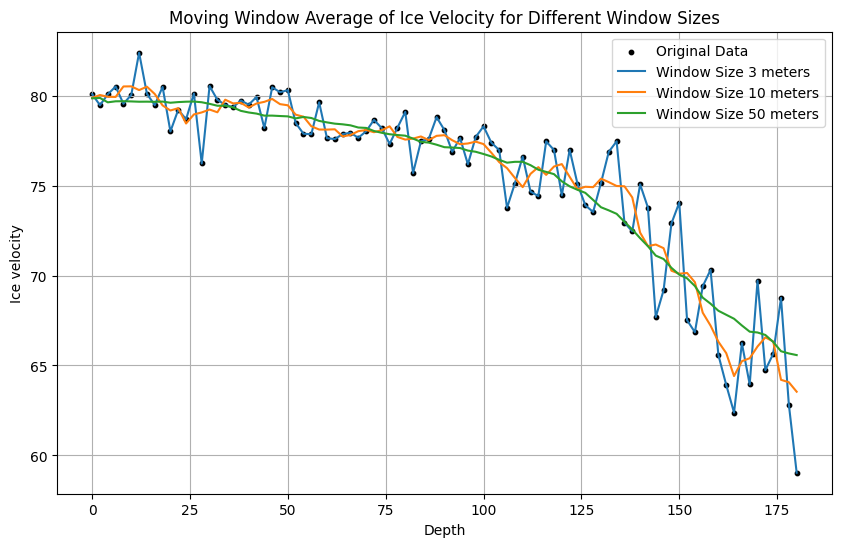

In [22]:
#4

# Define window sizes
window_sizes = [3, 10, 50]

# Define a function to calculate the moving window average
def moving_window_average(z, v, window_size):
    half_window = window_size / 2 # define half the window size so that the window is centered at each depth point.
    non_wv_smooth = np.zeros_like(v) # creates an array of the same shape as v, initialized with zeros, to store the smoothed velocity values.

    for i in range(len(z)):
        # Define the window range for depth
        z_min = z[i] - half_window # Defines the lower bound of the window, centered at z[i]
        z_max = z[i] + half_window # Defines the upper bound of the window, centered at z[i]

        # Find the indices of points within the window
        window_indices = np.where((z >= z_min) & (z <= z_max))[0] # finds indices within the window

        # Calculate the average velocity within the window
        non_wv_smooth[i] = np.mean(v[window_indices]) # take all the points in the window, and returns a mean to "smooth"

    return non_wv_smooth

# Dictionary to store the smoothed velocity for each window size
smoothed_velocities = {}

# Loop through each window size and calculate the smoothed velocity
for window in window_sizes:
    smoothed_velocities[window] = moving_window_average(z, v, window_size=window)

# Now, you can plot all the results in a loop as well
plt.figure(figsize=(10, 6))

# Plot original data
plt.scatter(z, v, color='black', label='Original Data', s=10)

# Plot each smoothed velocity curve
for window in window_sizes:
    plt.plot(z, smoothed_velocities[window], label=f'Window Size {window} meters')

plt.xlabel('Depth')
plt.ylabel('Ice velocity')
plt.title('Moving Window Average of Ice Velocity for Different Window Sizes')
plt.legend()
plt.grid(True)
plt.show()

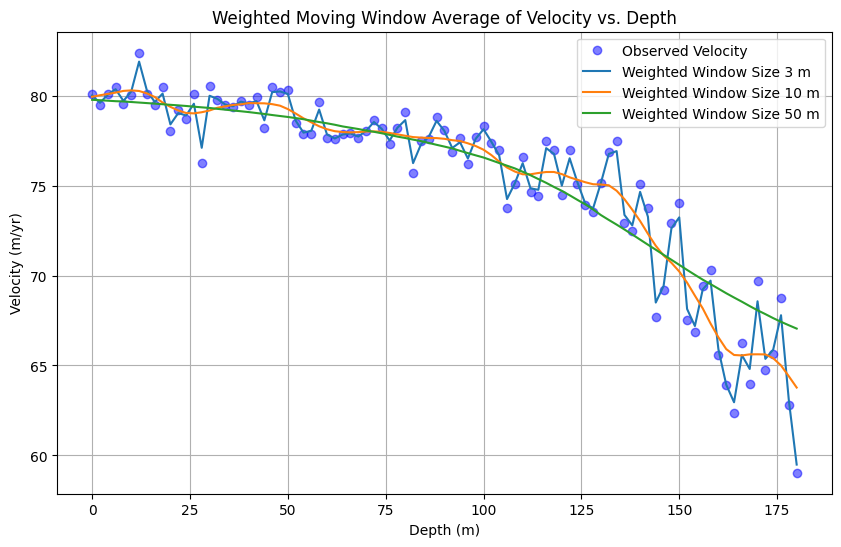

In [27]:
#5

def gaus_moving_window_average(z_sort, v_sort, window_size, step_size):
    v_smooth = np.zeros_like(v)
    half_window = window_size // 2

    for i in range(len(v)):
        start = max(0, i - half_window)
        end = min(len(v), i + half_window + 1)
        weights = np.exp(-0.5 * ((z[start:end] - z[i]) / half_window) ** 2)
        weights /= np.sum(weights)
        v_smooth[i] = np.sum(weights * v[start:end])

    return v_smooth

plt.figure(figsize=(10, 6))
plt.plot(z, v, 'bo', label='Observed Velocity', alpha=0.5)

for window_size in window_sizes:
    v_weighted_smooth = weighted_moving_average(z, v, window_size)
    plt.plot(z, v_weighted_smooth, label=f'Weighted Window Size {window_size} m')

plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.title('Weighted Moving Window Average of Velocity vs. Depth')
plt.legend()
plt.grid(True)
plt.show()



Optimal Window Size: 22


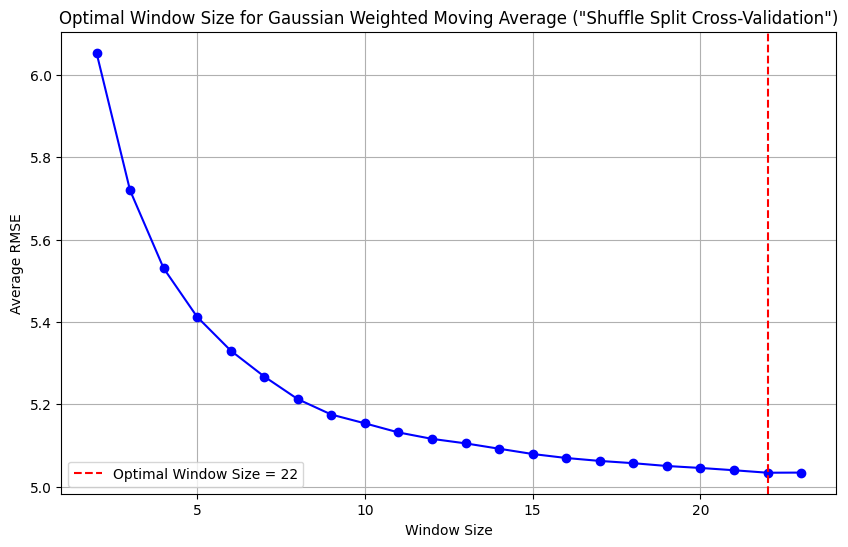

In [54]:
#6 Version 3
from sklearn.model_selection import ShuffleSplit

# Sort data by depth (z)
sorted_indices = np.argsort(D[:, 0])  # Get indices that would sort z
z_sorted = D[sorted_indices, 0]  # Sort z
v_sorted = D[sorted_indices, 1]  # Sort corresponding velocity values

# Convert to pandas Series for easier handling
z_series_sorted = pd.Series(z_sorted)
v_series_sorted = pd.Series(v_sorted)

# Define a function for calculating Gaussian weights
def gaussian_weights(window_size, sigma):
    center = window_size // 2
    distances = np.arange(window_size) - center
    weights = np.exp(-0.5 * (distances / sigma) ** 2)
    return weights / weights.sum()  # Normalize the weights

# Define a function for calculating the Gaussian weighted moving average (GWMA)
def gaussian_weighted_moving_average(data, window_size, sigma):
    weights = gaussian_weights(window_size, sigma)
    return np.convolve(data, weights, mode='valid')

# Define a function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Perform adaptive cross-validation to stop when RMSE starts increasing
def adaptive_cross_validate_gwma(z_series, v_series, sigma, start_window=2, max_window=50, n_iterations=1000, test_size=0.1):
    previous_rmse = float('inf')  # Start with an infinite RMSE to compare against
    optimal_window_size = start_window
    window_size = start_window
    rmse_per_window = []

    # Use ShuffleSplit for random train-test splits with the specified number of iterations
    shuffle_split = ShuffleSplit(n_splits=n_iterations, test_size=test_size, random_state=42)

    while window_size <= max_window:
        total_rmse = 0
        count = 0

        for train_index, test_index in shuffle_split.split(z_series):
            z_train, z_test = z_series.iloc[train_index], z_series.iloc[test_index]
            v_train, v_test = v_series.iloc[train_index], v_series.iloc[test_index]

            if len(v_train) < window_size:  # Ensure we can apply the moving average
                continue

            v_train_gwma = gaussian_weighted_moving_average(v_train, window_size, sigma)

            # Align test data and GWMA data by ensuring equal lengths
            v_test_aligned = v_test[:len(v_train_gwma)]  # Align test data to GWMA length
            v_train_gwma_aligned = v_train_gwma[:len(v_test_aligned)]  # Align GWMA to test data

            # Calculate RMSE for this split
            if len(v_test_aligned) > 0:
                rmse = calculate_rmse(v_test_aligned, v_train_gwma_aligned)
                total_rmse += rmse
                count += 1

        # Calculate the average RMSE for this window size
        avg_rmse = total_rmse / count if count > 0 else float('inf')
        rmse_per_window.append((window_size, avg_rmse))

        # Stop if the RMSE starts increasing
        if avg_rmse > previous_rmse:
            break

        # Update the optimal window size if RMSE is improving
        previous_rmse = avg_rmse
        optimal_window_size = window_size
        window_size += 1  # Increase the window size for the next iteration

    return optimal_window_size, rmse_per_window

# Define a sigma for the Gaussian function
sigma = 10  # Adjust sigma for the Gaussian weights

# Perform adaptive cross-validation to find the optimal window size with sorted data
optimal_window_size_sorted, rmse_per_window_sorted = adaptive_cross_validate_gwma(z_series_sorted, v_series_sorted, sigma, start_window=2, max_window=25, n_iterations=1000, test_size=0.1)

# Output the optimal window size
print(f'Optimal Window Size: {optimal_window_size_sorted}')

# Plot the RMSE vs window sizes
window_sizes, rmses = zip(*rmse_per_window_sorted)
plt.figure(figsize=(10, 6))
plt.plot(window_sizes, rmses, marker='o', linestyle='-', color='b')
plt.axvline(x=optimal_window_size_sorted, color='red', linestyle='--', label=f'Optimal Window Size = {optimal_window_size_sorted}')
plt.xlabel('Window Size')
plt.ylabel('Average RMSE')
plt.title('Optimal Window Size for Gaussian Weighted Moving Average ("Shuffle Split Cross-Validation")')
plt.legend()
plt.grid(True)
plt.show()


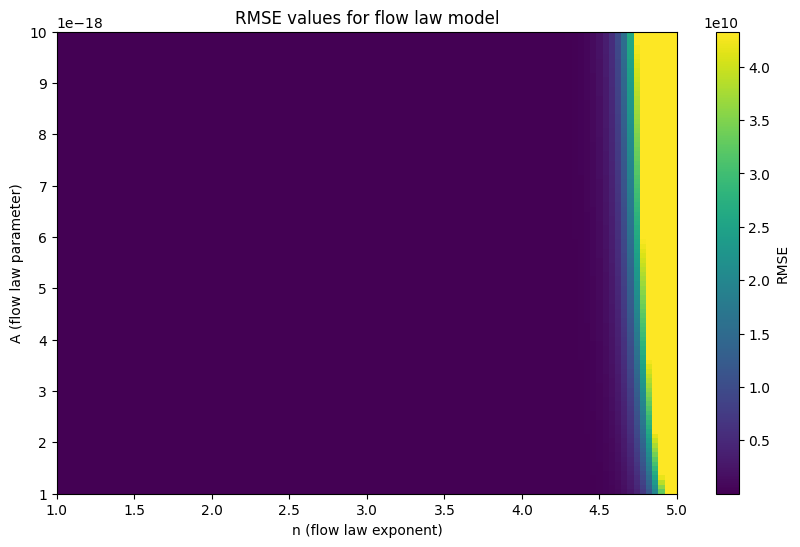

Optimal A: 1.0000e-17
Optimal n: 2.9394
Minimum RMSE: 1.9589


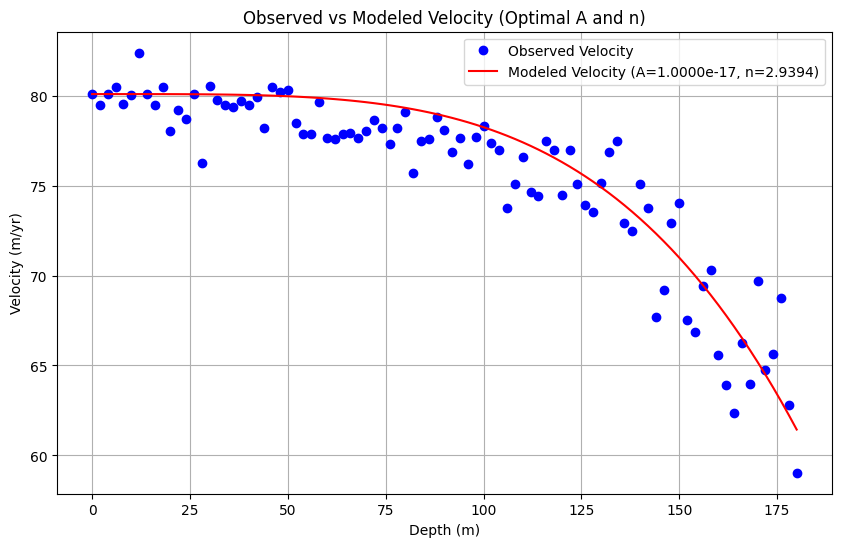

In [84]:
#7

# Constants
g = 9.8  # m/s^2, gravitational acceleration
rho = 917  # kg/m^3, density of ice
theta = np.radians(10)  # Convert 10 degrees to radians

# Surface velocity (at z = 0 m)
u_surf = v[0]  # Surface velocity (m/yr)

# Define the flow law model
def model_velocity(A, n, z, u_surf):
    return u_surf - A * (rho * g * np.sin(theta))**n * z**(n + 1)

# Define the range of values for A and n
A_values = np.linspace(1e-18, 10e-18, 100)  # Values of A from 1e-18 to 10e-18 in 100 steps
n_values = np.linspace(1, 5, 100)  # Values of n from 1 to 5

# Initialize an RMSE array to store the error values
rmse = np.zeros((len(A_values), len(n_values)))

# Calculate RMSE between modeled and observed velocities for each combination of A and n
for i, A in enumerate(A_values):
    for j, n in enumerate(n_values):
        v_model = model_velocity(A, n, z, u_surf)  # Calculate modeled velocity
        rmse[i, j] = np.sqrt(np.mean((v_model - v) ** 2))  # Calculate RMSE

# Plot RMSE as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(rmse, extent=[n_values.min(), n_values.max(), A_values.min(), A_values.max()],
           aspect='auto', origin='lower', cmap='viridis', vmin=np.percentile(rmse, 5), vmax=np.percentile(rmse, 95))
plt.colorbar(label='RMSE')
plt.xlabel('n (flow law exponent)')
plt.ylabel('A (flow law parameter)')
plt.title('RMSE values for flow law model')
plt.show()

# Find the index of the minimum RMSE
min_rmse_idx = np.unravel_index(np.argmin(rmse), rmse.shape)
best_A = A_values[min_rmse_idx[0]]
best_n = n_values[min_rmse_idx[1]]

# Print the optimal values of A and n
print(f'Optimal A: {best_A:.4e}')
print(f'Optimal n: {best_n:.4f}')
print(f'Minimum RMSE: {rmse[min_rmse_idx]:.4f}')

# Plot observed vs modeled velocities using the optimal A and n
v_model_best = model_velocity(best_A, best_n, z, u_surf)

plt.figure(figsize=(10, 6))
plt.plot(z, v, 'bo', label='Observed Velocity')
plt.plot(z, v_model_best, 'r-', label=f'Modeled Velocity (A={best_A:.4e}, n={best_n:.4f})')
plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.title('Observed vs Modeled Velocity (Optimal A and n)')
plt.legend()
plt.grid(True)
plt.show()


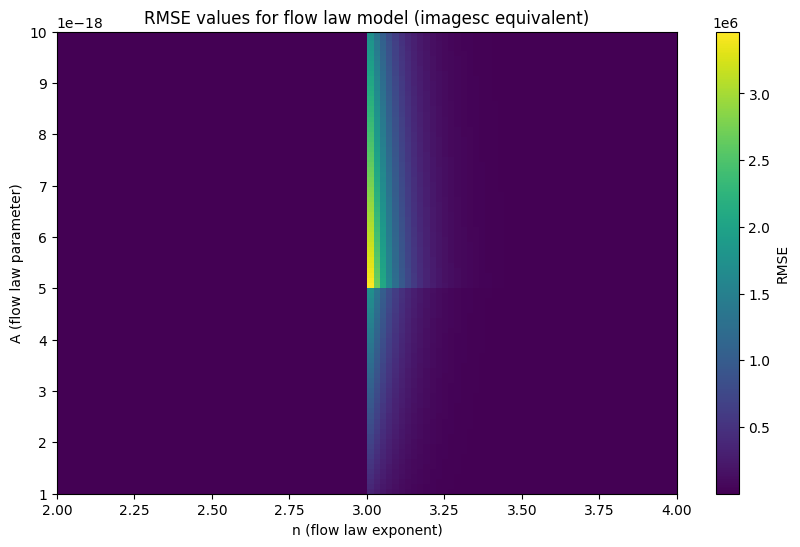

Optimal A: 8.0000e-18
Optimal n: 2.9592
Minimum RMSE: 1.9550


In [59]:
#8

# Calculate RMSE between modeled and observed velocities
for i in range(len(A_values)):
    for j in range(len(n_values)):
        v_model = model_velocity(A_values[i], n_values[j], z, u_surf)
        # Calculate RMSE and store it in the array
        rmse[i, j] = np.sqrt(np.mean((v_model - v)**2))

# Plot RMSE using a MATLAB-like imagesc approach
plt.figure(figsize=(10, 6))
plt.imshow(rmse, extent=[n_values.min(), n_values.max(), A_values.min(), A_values.max()],
           aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='RMSE')
plt.xlabel('n (flow law exponent)')
plt.ylabel('A (flow law parameter)')
plt.title('RMSE values for flow law model (imagesc equivalent)')
plt.show()

# Find the index of the minimum RMSE
min_rmse_idx = np.unravel_index(np.argmin(rmse), rmse.shape)
best_A = A_values[min_rmse_idx[0]]
best_n = n_values[min_rmse_idx[1]]

# Print the optimal values of A and n
print(f'Optimal A: {best_A:.4e}')
print(f'Optimal n: {best_n:.4f}')
print(f'Minimum RMSE: {rmse[min_rmse_idx]:.4f}')


Optimization terminated successfully.
         Current function value: 1.812966
         Iterations: 464
         Function evaluations: 851
Optimal A: 1.1040e-12
Optimal n: 2.0077


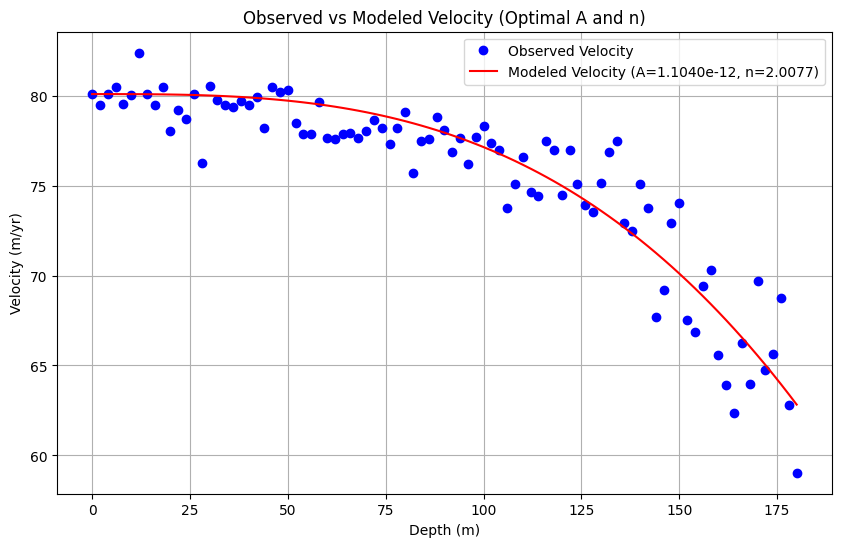

In [74]:
#9
from scipy.optimize import fmin

# Find the optimum values of A and n using gradient search method with MATLAB's fminsearch equivalent
initial_guess = [1e-16, 3]  # Initial guess for A and n

# Objective function to minimize
def rmin(params, z, v, u_surf):
    A, n = params
    v_model = model_velocity(A, n, z, u_surf)
    rmse = np.sqrt(np.mean((v_model - v) ** 2))
    return rmse

# Use scipy's minimize function to find the optimal A and n
result = fmin(rmin, initial_guess, args=(z, v, u_surf), maxiter=1000, maxfun=1000)

# Extract the optimal values of A and n
best_A, best_n = result

# Print the optimal values of A and n
print(f'Optimal A: {best_A:.4e}')
print(f'Optimal n: {best_n:.4f}')

# Plot observed vs modeled velocities using the optimal A and n
v_model_best = model_velocity(best_A, best_n, z, u_surf)

plt.figure(figsize=(10, 6))
plt.plot(z, v, 'bo', label='Observed Velocity')
plt.plot(z, v_model_best, 'r-', label=f'Modeled Velocity (A={best_A:.4e}, n={best_n:.4f})')
plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.title('Observed vs Modeled Velocity (Optimal A and n)')
plt.legend()
plt.grid(True)
plt.show()

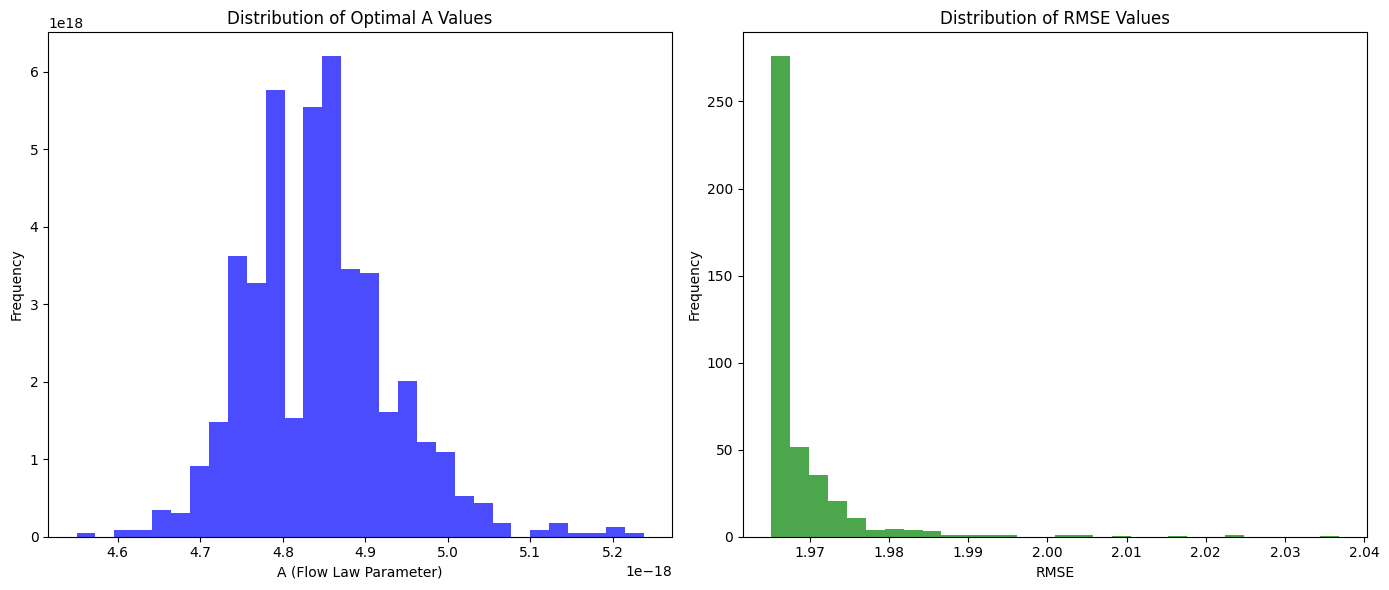

In [77]:
#10
import random

# Define the objective function to minimize (RMSE)
def objective(params, z, v, u_surf, n):
    A = params[0]
    v_model = model_velocity(A, n, z, u_surf)
    rmse = np.sqrt(np.mean((v_model - v) ** 2))
    return rmse

# Parameters for the sampling
n_iterations = 1000
n_samples = int(0.9 * len(z))
n = 3  # Fix n to 3 as specified

# Store results
A_values = []
rmse_values = []

# Repeat the gradient search 1000 times with 90% random sampling
for _ in range(n_iterations):
    # Randomly sample 90% of the dataset
    sample_indices = random.sample(range(len(z)), n_samples)
    z_sample = z[sample_indices]
    v_sample = v[sample_indices]

    # Initial guess for A
    initial_guess = [1e-18]

    # Use scipy's fmin function to find the optimal A
    result = fmin(objective, initial_guess, args=(z_sample, v_sample, u_surf, n), disp=False)

    # Extract the optimal value of A
    best_A = result[0]
    A_values.append(best_A)

    # Calculate RMSE for the entire dataset using the optimal A
    v_model = model_velocity(best_A, n, z, u_surf)
    rmse = np.sqrt(np.mean((v_model - v) ** 2))
    rmse_values.append(rmse)

# Plot the distribution of A and RMSE using a relative density histogram
plt.figure(figsize=(14, 6))

# Histogram for A values
plt.subplot(1, 2, 1)
plt.hist(A_values, bins=30, density=True, color='blue', alpha=0.7)
plt.xlabel('A (Flow Law Parameter)')
plt.ylabel('Frequency')
plt.title('Distribution of Optimal A Values')

# Histogram for RMSE values
plt.subplot(1, 2, 2)
plt.hist(rmse_values, bins=30, density=True, color='green', alpha=0.7)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE Values')

plt.tight_layout()
plt.show()

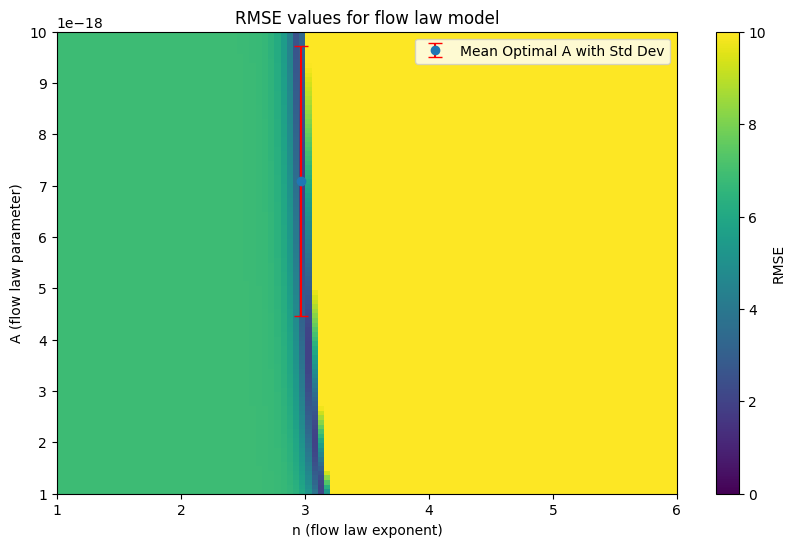

In [85]:
#11

import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.8  # m/s^2, gravitational acceleration
rho = 917  # kg/m^3, density of ice
theta = np.radians(10)  # Convert 10 degrees to radians

# Load the ice velocity data (depth z and observed velocity v)
z = D[:, 0]  # Depth values (m)
v = D[:, 1]  # Observed velocities (m/yr)

# Surface velocity (at z = 0 m)
u_surf = v[0]  # Surface velocity (m/yr)

# Define the range of values for A and n
A_values = np.linspace(1e-18, 10e-18, 100)  # Values of A from 1e-18 to 10e-18 in 100 steps
n_values = np.linspace(1, 6, 100)  # Values of n from 1 to 5

# Initialize an RMSE array to store the error values
rmse = np.zeros((len(A_values), len(n_values)))

# Define the flow law model
def model_velocity(A, n, z, u_surf):
    return u_surf - A * (rho * g * np.sin(theta))**n * z**(n + 1)

# Calculate RMSE between modeled and observed velocities
for i in range(len(A_values)):
    for j in range(len(n_values)):
        v_model = model_velocity(A_values[i], n_values[j], z, u_surf)

      # Calculate RMSE and store it in the array
        rmse[i, j] = np.sqrt(np.mean((v_model - v)**2))

# Plot RMSE as a heatmap
plt.figure(figsize=(10, 6))
plt.clf()
plt.imshow(rmse, extent=[n_values.min(), n_values.max(), A_values.min(), A_values.max()],
           aspect='auto', origin='lower', vmin= 0, vmax=10)
plt.colorbar(label='RMSE')


# Calculate mean and standard deviation of the optimal A values
min_rmse_idx = np.unravel_index(np.argmin(rmse), rmse.shape)
mean_A = A_values[min_rmse_idx[0]]
std_A = np.std(A_values)

# Add mean and standard deviation as vertical error bars
plt.errorbar(x=n_values[min_rmse_idx[1]], y=mean_A, yerr=std_A, fmt='o', ecolor='red', capsize=5, label='Mean Optimal A with Std Dev')
plt.xlabel('n (flow law exponent)')
plt.ylabel('A (flow law parameter)')
plt.title('RMSE values for flow law model')
plt.legend()
plt.show()



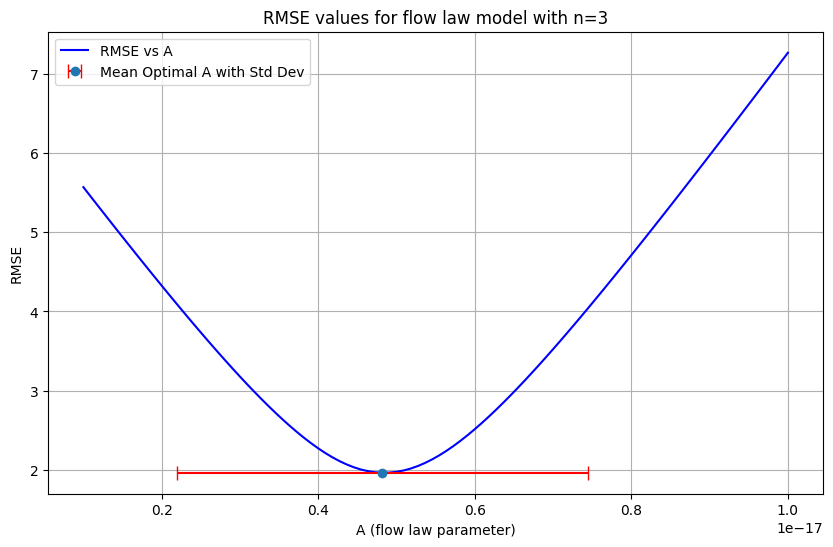

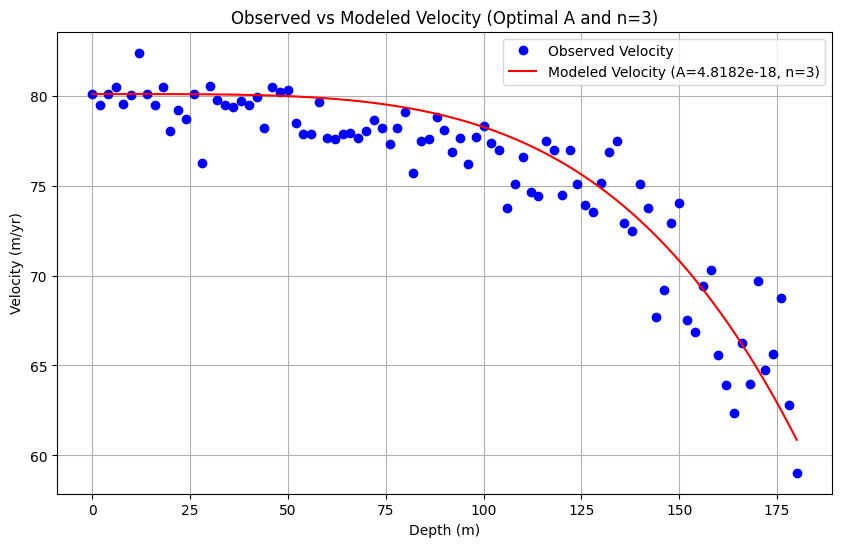

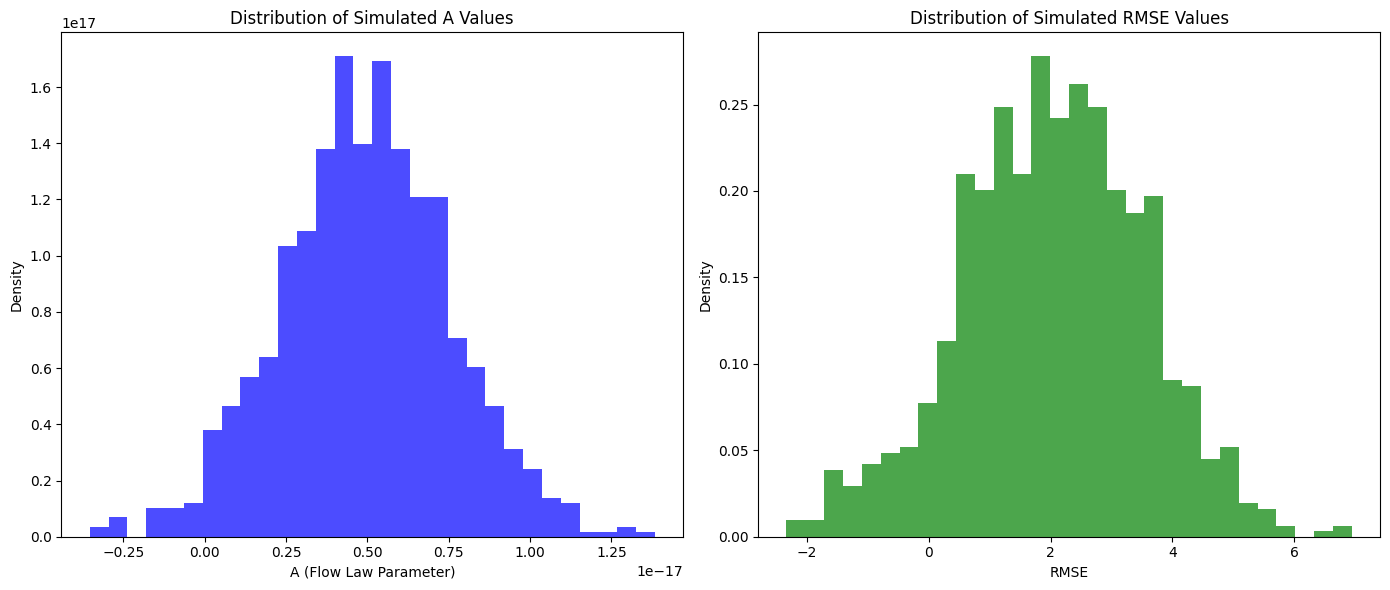

In [92]:
#12
n = 3  # Fix n to 3 as specified

# Initialize an RMSE array to store the error values
rmse = np.zeros(len(A_values))



# Calculate RMSE between modeled and observed velocities
for i in range(len(A_values)):
    v_model = model_velocity(A_values[i], n, z, u_surf)
    # Calculate RMSE and store it in the array
    rmse[i] = np.sqrt(np.mean((v_model - v)**2))

# Plot RMSE as a function of A
plt.figure(figsize=(10, 6))
plt.plot(A_values, rmse, 'b-', label='RMSE vs A')
plt.xlabel('A (flow law parameter)')
plt.ylabel('RMSE')
plt.title('RMSE values for flow law model with n=3')
plt.grid(True)

# Calculate mean and standard deviation of the optimal A values
mean_A = A_values[np.argmin(rmse)]
std_A = np.std(A_values)

# Add mean and standard deviation as vertical error bars
plt.errorbar(mean_A, np.min(rmse), xerr=std_A, fmt='o', ecolor='red', capsize=5, label='Mean Optimal A with Std Dev')
plt.legend()
plt.show()

# Plot observed vs modeled velocities using the optimal A
v_model_best = model_velocity(mean_A, n, z, u_surf)

plt.figure(figsize=(10, 6))
plt.plot(z, v, 'bo', label='Observed Velocity')
plt.plot(z, v_model_best, 'r-', label=f'Modeled Velocity (A={mean_A:.4e}, n={n})')
plt.xlabel('Depth (m)')
plt.ylabel('Velocity (m/yr)')
plt.title('Observed vs Modeled Velocity (Optimal A and n=3)')
plt.legend()
plt.grid(True)
plt.show()

# Generate 1000 simulated values for A and RMSE using normal distribution
np.random.seed(40)  # For reproducibility
simulated_A_values = np.random.normal(mean_A, std_A, 1000)
simulated_rmse_values = np.random.normal(np.min(rmse), np.std(rmse), 1000)

# Plot the distribution of simulated A values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(simulated_A_values, bins=30, density=True, color='blue', alpha=0.7)
plt.xlabel('A (Flow Law Parameter)')
plt.ylabel('Density')
plt.title('Distribution of Simulated A Values')

# Plot the distribution of simulated RMSE values
plt.subplot(1, 2, 2)
plt.hist(simulated_rmse_values, bins=30, density=True, color='green', alpha=0.7)
plt.xlabel('RMSE')
plt.ylabel('Density')
plt.title('Distribution of Simulated RMSE Values')

plt.tight_layout()
plt.show()


In [96]:
from scipy.stats import ks_2samp

# Perform two-sample KS test to compare the actual distributions with simulated distributions
ks_stat_A, p_value_A = ks_2samp(A_values, simulated_A_values)
print(f'KS Test for A values: ks Stat={ks_stat_A:.4f}, p-value={p_value_A:.4f}')

ks_stat_rmse, p_value_rmse = ks_2samp(rmse.flatten(), simulated_rmse_values)
print(f'KS Test for RMSE values: ks Stat={ks_stat_rmse:.4f}, p-value={p_value_rmse:.6f}')

KS Test for A values: ks Stat=0.1350, p-value=0.0673
KS Test for RMSE values: ks Stat=0.4720, p-value=0.000000
